In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate();
Pkg.add("ForwardDiff")
Pkg.add("RobotDynamics")
Pkg.add("LinearAlgebra")
Pkg.add("StaticArrays")
Pkg.add("SparseArrays")
Pkg.add("Plots")
Pkg.add("Printf")
using ForwardDiff
using Test
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using Plots
# using PyPlots
using Printf

# include("quadratic_cost.jl")


 Activating environment at `~/Desktop/Home/CMU/2021 Courses/16745 OC/Project.toml`
   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/Desktop/Home/CMU/2021 Courses/16745 OC/Project.toml`
No Changes to `~/Desktop/Home/CMU/2021 Courses/16745 OC/Manifest.toml`
  Resolving package versions...
No Changes to `~/Desktop/Home/CMU/2021 Courses/16745 OC/Project.toml`
No Changes to `~/Desktop/Home/CMU/2021 Courses/16745 OC/Manifest.toml`
  Resolving package versions...
No Changes to `~/Desktop/Home/CMU/2021 Courses/16745 OC/Project.toml`
No Changes to `~/Desktop/Home/CMU/2021 Courses/16745 OC/Manifest.toml`
  Resolving package versions...
No Changes to `~/Desktop/Home/CMU/2021 Courses/16745 OC/Project.toml`
No Changes to `~/Desktop/Home/CMU/2021 Courses/16745 OC/Manifest.toml`
  Resolving package versions...
No Changes to `~/Desktop/Home/CMU/2021 Courses/16745 OC/Pr

# Final Project Info
In this we present a geostationary transfer orbit to a geosynchronous (GSO) or geostationary orbit (GEO).  We use Keplerian Orbital Dynamics to model our system. We make several assumptions like Earth Reference Frame, Spherical Earth, Kepler Dynamics. 

## The Model
We'll be using the Kepler Dynamics:

$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$

$$ 
\ddot{r} = F = \frac{-\mu}{\norm{r}^3}*r+u \\
x = [r, \dot{r}] \\
\norm{u} \le Tmax
$$
with the following model parameters:
* $\mu$: Gravitational Parameter = 63781
* $r$: distance to earth center
* $u$: control of ion thruster

In [60]:
# Problem Setup
# Dont want KM and S
# Rescale unite to order 1
# Length unit = SMA 
# Time scale = T orbit period
# Helps condition number 

# TODO Rescale μ 
# Hint can take big steps 10 knot points per-orbit



# model = Kepler() # TODO
# n,m = size(model)          # state and control dimensions
dt = 0.025                 # time step (sec)
tf = 1.5                   # time horizon (sec)
T = Int(tf/dt) + 1         # number of time steps

# Initial & final condition

#cartesian and ECI
#x,y,z,vx,vy,vz
earthRadius = 6378.1 # [km]
LEO = 500 #km above sealevel #circular low earth orbit # 250km 
GSO = 35786 #km above sealevel #circular geosychonous orbit
μ = 3.986*10e5 #gravitational parameter [km^3 s^2]


semiMajorAxis_transfer = (GSO+earthRadius+earthRadius+LEO)/2
instantRadius = earthRadius+LEO
instantVelocity = sqrt(2*μ/(instantRadius)-1/(semiMajorAxis))
x0    = [instantRadius, 0.0, 0.0, 0.0, instantVelocity, 0.0] # initial state #geosynchronous transfer orbit (GTO, where rocket dropped satellite off)
                                                                             #many kilometers above Africa in an elliptical orbit 
semiMajorAxis = 2*(earthRadius+GSO)/2
instantRadius = earthRadius+LEO
instantVelocity = sqrt(μ*(2.0/instantRadius-1.0/semiMajorAxis_transfer)) #sqrt(2*μ/(instantRadius)-1/(semiMajorAxis)) # VisViva
xgoal = [instantRadius, 0.0, 0.0, 0.0, instantVelocity, 0.0] # goal state #circular geosychonous orbit above africa

ugto = zeros(3)                  # hover controls

# Cost matrices
# Q = #TODO  #Diagonal(SVector{6}([ones(3) ; fill(0.1, 3)]))
# R = #TODO  #Diagonal(@SVector fill(1e-2, m))
# Qf = #TODO #Diagonal(@SVector fill(1e2, n));

In [61]:
sqrt(4*3.14159^2*instantRadius^3/μ)

1795.2030725491793

In [62]:
pi

π = 3.1415926535897...

## Dynamics

In [63]:
function dynamics(x, u)
    # x = state [x, y, z, dx, dy, dz]
    # u = control [ux, uy, uz]
    r = x[1:3]
    ṙ = x[4:end]
    r̈ = (-μ/(norm(r)^3))*r + u
    return [ṙ; r̈]
end

dynamics (generic function with 1 method)

In [64]:
function integrator!(x, u, h)
    # x = state
    # u = control
    # h = time step
#     ẋ = dynamics(x, u)
    f1 = dynamics(x, u)
    f2 = dynamics(x + 0.5*h*f1, u)
    f3 = dynamics(x + 0.5*h*f2, u)
    f4 = dynamics(x + h*f3, u)
    x .+= (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

integrator! (generic function with 1 method)

In [65]:
function get_energy(x)
    return norm(x[4:end])^2/2 - μ/norm(x[1:3])
end

get_energy (generic function with 1 method)

In [66]:
h = 10.0 
t = range(0, 5400, step=h) # time in second 90min
traj = zeros(size(t)[1], size(x0)[1])
# print(size(traj))
x = deepcopy(xgoal)
traj[1,:] .= x

u = zeros(3)
energy = zero(t)
energy[1] = get_energy(x)
for i in 2:size(t)[1]
    integrator!(x, u, h)
    traj[i,:] .= x
    energy[i] = get_energy(x)
end
    

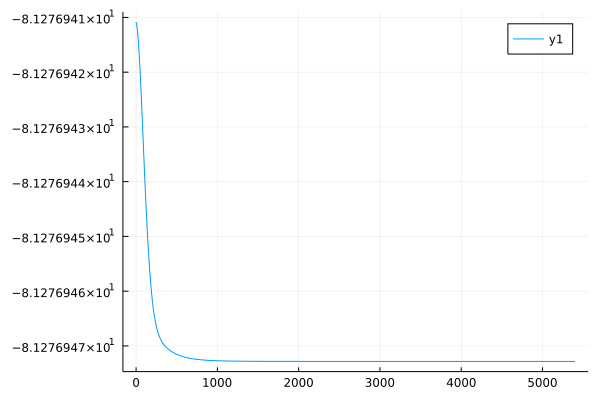

In [67]:
plot(t, energy)

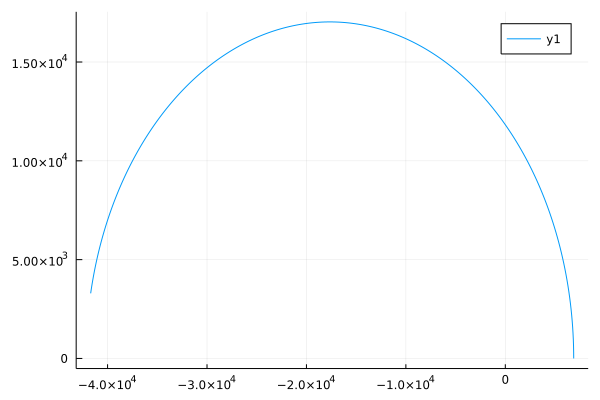

In [68]:
plot(traj[:, 1], traj[:, 2])
# TODO plot earth origin 

# plot(t, traj[:, 5])
# plot!(t, traj[:, 4])
# for point in traj
#     plot!(point[1], point[2])
# end

In [ ]:
# initialize a 3D plot with 1 empty series
plt = plot3d(
    1,
    xlim = (-50000, 50000),
    ylim = (-50000, 50000),
    zlim = (-50000, 50000),
    title = "Satalite Orbit",
    marker = 2,
)



# build an animated gif by pushing new points to the plot, saving every 10th frame
@gif for i in 1:size(t)[1]
#     step!(attractor)
    push!(plt, traj[i,1], traj[i,2], traj[i,3])
end every 1


## Part (a): Implement DIRCOL 
Implement DIRCOL by completing the provided methods. 

In [ ]:
"""
    Problem{n,m,L}

Describes a trajectory optimization problem with `n` states, `m` controls, and 
a model of type `L`. 

# Constructor
    Problem(model::L, obj::Vector{<:QuadraticCost{n,m}}, tf, x0, xf) where {n,m,L}

where `tf` is the final time, and `x0` is the initial state. 
"""
struct Problem{n,m,L}
    # TODO 
end
Base.size(prob::Problem{n,m}) where {n,m} = (n,m,prob.T)

In [ ]:
# Cost function
# TODO 

# Build Problem
prob = Problem(model, obj, tf, x0);
n,m,T = size(prob)   # get problem dimensions

# Random trajectory
Xrand =  # TODO 
Urand = # TODO 

# Evaluate the cost
# t = prob.times[1]
# dt = prob.times[2]-prob.times[1]
# cost(prob.obj, Xrand, Urand)

# Evaluate the dynamics
# TODO

### DIRCOL Algorithm

In [ ]:
# TASK: Complete implement DIRCOL Algo



### Forward Pass

In [ ]:
# TASK: Complete forward simulation of satelite 

## Part (b): Simple trajectory 
Planar example with quibit interpolation and no Thurst conditions

In [ ]:
# Task Solve Simple Trajectory

In [ ]:
# vis = Visualizer()
# set_mesh!(vis, model)
# render(vis)

In [ ]:
# visualize!(vis, model, tf, Xline)

## Part (c): Higher Order DIRCOL
Solve the simple planar problem with unconstrained thrust with higher order DIRCOL 3->8th order

In [ ]:
# TASK: Implement the following method

In [ ]:
# TASK: Plot the comparison


## Part (d): Inequality Constraints 
Using the thruster constraints solve the optimization problem

In [ ]:
# TASK: Inequality constraints

In [ ]:
# render(vis)

In [ ]:
# visualize!(vis, model, tf, Xflip)

## Part (e): Non-Planar Satellite Control


In [ ]:
# TASK: Non-Planar Control

## TESTS

In [ ]:
# run_tests();